In [52]:
# TODO 
# transfer learning
# box bounding before keypoints prediction
# SineReLU
# fit_one_cycle with keras
# fastai/pytorch
# fully connected network

In [53]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from random import randint

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import (Dense, Activation, SeparableConv2D, MaxPooling2D, Flatten, Dropout, 
                          BatchNormalization)
from keras.optimizers import Adam

import imgaug
from imgaug import augmenters as iaa
from imgaug.augmentables.kps import Keypoint, KeypointsOnImage

from preprocess import load, generator
from utils import plot_labelled_image, plot_labelled_sample, plot_loss, load_model, save_model
from model import MyModel
from clr import LRFinder, OneCycleLR

In [55]:
images_path = '../data/images/'
labels_path = '../data/landmarks.csv'
target_size = 80

In [57]:
X, y = load(images_path, labels_path, target_size)

X_train, X_test_, y_train, y_test_ = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test_, y_test_, test_size=0.5, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)

/home/jupyter/facial_features/code/preprocess.py:50: ResourceWarning: unclosed file <_io.BufferedReader name='../data/images/Egyptian_Mau_139.jpg'>
  img = np.array(Image.open(images_path+filename))
/home/jupyter/facial_features/code/preprocess.py:50: ResourceWarning: unclosed file <_io.BufferedReader name='../data/images/Egyptian_Mau_145.jpg'>
  img = np.array(Image.open(images_path+filename))
/home/jupyter/facial_features/code/preprocess.py:50: ResourceWarning: unclosed file <_io.BufferedReader name='../data/images/Egyptian_Mau_167.jpg'>
  img = np.array(Image.open(images_path+filename))
/home/jupyter/facial_features/code/preprocess.py:50: ResourceWarning: unclosed file <_io.BufferedReader name='../data/images/Egyptian_Mau_177.jpg'>
  img = np.array(Image.open(images_path+filename))
/home/jupyter/facial_features/code/preprocess.py:50: ResourceWarning: unclosed file <_io.BufferedReader name='../data/images/Egyptian_Mau_191.jpg'>
  img = np.array(Image.open(images_path+filename))


(4192, 160, 160, 3) (898, 160, 160, 3) (899, 160, 160, 3)


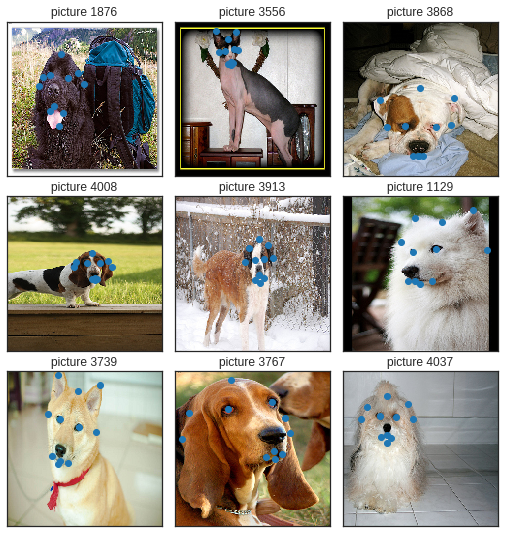

In [59]:
plot_labelled_sample(X_train, y_train, target_size, False)

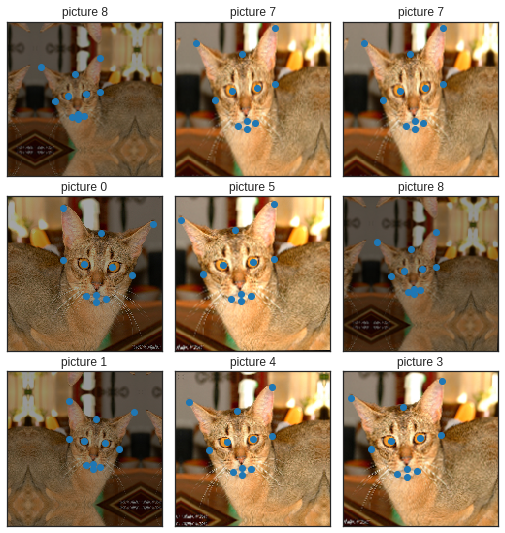

In [60]:
for a, b in generator(X[2:3], y.iloc[2:3], 9, target_size):
    plot_labelled_sample(a, b, target_size)   
    break

In [61]:
model = MyModel(target_size, 1e-3)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_49 (Separab (None, 158, 158, 32)      155       
_________________________________________________________________
separable_conv2d_50 (Separab (None, 156, 156, 64)      2400      
_________________________________________________________________
batch_normalization_25 (Batc (None, 156, 156, 64)      256       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 78, 78, 64)        0         
_________________________________________________________________
separable_conv2d_51 (Separab (None, 76, 76, 64)        4736      
_________________________________________________________________
separable_conv2d_52 (Separab (None, 74, 74, 128)       8896      
_________________________________________________________________
batch_normalization_26 (Batc (None, 74, 74, 128)       512       
__________

In [62]:
epochs = 50
batch_size = 128
max_lr = 0.001

callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='../models/my_model.h5',
        monitor='val_loss',
        save_best_only=True,
    )
]

hist = model.fit_generator(
    generator(X_train, y_train, batch_size=batch_size, target_size=target_size), 
    steps_per_epoch=len(X_train)/batch_size, 
    epochs=epochs,
    callbacks=callbacks_list,
    validation_data=(X_val/255, (y_val - (target_size/2)) / (target_size/2))
)

Epoch 1/50
33/32 [==============================] - 458s 14s/step - loss: 0.4213 - val_loss: 0.1090
Epoch 2/50
33/32 [==============================] - 449s 14s/step - loss: 0.1063 - val_loss: 0.0911
Epoch 3/50
33/32 [==============================] - 449s 14s/step - loss: 0.0942 - val_loss: 0.0761
Epoch 4/50
33/32 [==============================] - 447s 14s/step - loss: 0.0894 - val_loss: 0.0764
Epoch 5/50
33/32 [==============================] - 446s 14s/step - loss: 0.0862 - val_loss: 0.0744
Epoch 6/50
33/32 [==============================] - 445s 13s/step - loss: 0.0823 - val_loss: 0.0730
Epoch 7/50
33/32 [==============================] - 446s 14s/step - loss: 0.0793 - val_loss: 0.0747
Epoch 8/50
33/32 [==============================] - 445s 13s/step - loss: 0.0789 - val_loss: 0.0699
Epoch 9/50
33/32 [==============================] - 444s 13s/step - loss: 0.0780 - val_loss: 0.0695
Epoch 10/50
13/32 [==========>...................] - ETA: 4:13 - loss: 0.0801

KeyboardInterrupt: 

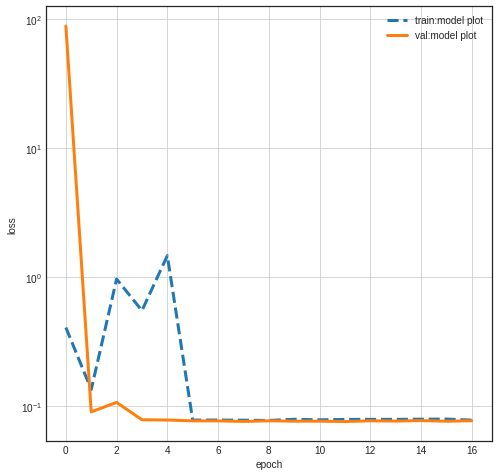

In [63]:
plot_loss(hist, "model plot")

In [64]:
model.load_weights('../models/my_model.h5')

In [65]:
model = load_model("my_model")
save_model(model, "my_model")

In [66]:
y_pred = pd.DataFrame(model.predict(X_test/255))

ValueError: Error when checking input: expected conv2d_1_input to have shape (80, 80, 3) but got array with shape (160, 160, 3)

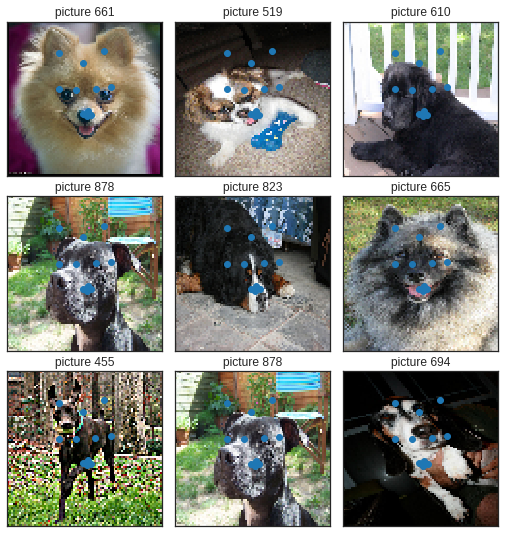

In [51]:
plot_labelled_sample(X_test/255, (y_pred - (target_size/2)) / (target_size/2), target_size)